# Covid-19 Forecasting using an RNN

The goal of this notebook is very simple: Generate additional features from the Covid19-global-forecasting dataset and feed it into an RNN. The RNN will take as inputs:
*     number of cases for 13 days
*     number of fatalities for 13 days
*     restrictions applied for the area in the past 13 days
*     quarantine applied for the area in the past 13 days
*     school opened or closed for the area in the past 13 days
*     additional information related to the area (population, density, number of hospital beds, lung measurement) 

as outputs:
*    number of cases for the 14th day
*    number of fatalities for the 14th day

* **V5**: Submission pipeline fixed - *score: 3.50412*
* **V6**: New RNN architecture with two separate branches for each output - *score: 2.94372*
* **V8**: Add a post-processing step checking if the model's output is equal or greater the previous value - *score: 2.49449*
* **V9**: Change the MSE losses to RMSLE - *score: 1.58228*
* **V11**: Change the outputs' activation fucntions from linear to ReLU - *score: 1.41954*
* **V12**: Use a 2-week period for predictions instead of 1. Replace the SimpleRNN layers with LSTM layers - *score: 1.17620*
* **V13**: Fix bug in Cell 4 (flagged by [@jeremyoudin](https://www.kaggle.com/jeremyoudin)) which made the dataset much larger due to duplicates and also created a leakage between the training and validation sets - *score: 1.25741*
* **V15**: Start introducing new inputs from the [enriched dataset](https://www.kaggle.com/optimo/covid19-enriched-dataset-week-2) by [@optimo](https://www.kaggle.com/optimo) and fix a bug which prevented the generation of 25% of the training data - *score: 0.87340*
* **V16**: Add a new input to the model based on the coutries' total population. It is added as a separate input as it is not temporal like all previous inputs - *score: 0.86465*
* **V18**: Use additional inputs using the enriched dataset. It makes the model more complex and harder to train but might be worth it! 

*PS: Please note that the scores may have change slightly. I assume that the evaluation method has been updated in some minor way during the competition.*

In [2]:
import sys
sys.executable

'C:\\Users\\SSG\\scoop\\apps\\anaconda3\\current\\envs\\kg37\\python.exe'

In [26]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [20]:
import tensorflow.keras as tfk

In [5]:
tf.__file__

'C:\\Users\\SSG\\scoop\\apps\\anaconda3\\current\\envs\\kg37\\lib\\site-packages\\tensorflow\\__init__.py'

In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from tensorflow.keras.layers  import LSTM, Concatenate, Dense, Dropout
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

for dirname, _, filenames in os.walk('D:/kaggle/covid19/covid19-global-forecasting-week-2/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

ModuleNotFoundError: No module named 'tensorflow.keras.layers'; 'tensorflow.keras' is not a package

In [2]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
tf.__file__

'C:\\Users\\SSG\\scoop\\apps\\anaconda3\\current\\envs\\kg37\\lib\\site-packages\\tensorflow\\__init__.py'

# Preparing the training data

In [2]:
train_df = gpd.read_file("/kaggle/input/enriched-covid-19-week2/enriched_covid_19_week_2.csv")
train_df["Country_Region"] = [country_name.replace("'","") for country_name in train_df["Country_Region"]]
train_df["restrictions"] = train_df["restrictions"].astype("int")
train_df["quarantine"] = train_df["quarantine"].astype("int")
train_df["schools"] = train_df["schools"].astype("int")
train_df["total_pop"] = train_df["total_pop"].astype("float")
train_df["density"] = train_df["density"].astype("float")
train_df["hospibed"] = train_df["hospibed"].astype("float")
train_df["lung"] = train_df["lung"].astype("float")
train_df["total_pop"] = train_df["total_pop"]/max(train_df["total_pop"])
train_df["density"] = train_df["density"]/max(train_df["density"])
train_df["hospibed"] = train_df["hospibed"]/max(train_df["hospibed"])
train_df["lung"] = train_df["lung"]/max(train_df["lung"])
train_df.head()

,Id,Country_Region,Province_State,Date,ConfirmedCases,Fatalities,age_0-4,age_5-9,age_10-14,age_15-19,...,density,urbanpop,hospibed,lung,femalelung,malelung,restrictions,quarantine,schools,geometry
0,1,Afghanistan,,2020-01-22,0.0,0.0,0.1457166900587929,0.13913315751113053,0.13337619499377074,0.1189222268680805,...,0.002278,25.0,0.036232,0.329191,36.31,39.33,0,0,0,None
1,2,Afghanistan,,2020-01-23,0.0,0.0,0.1457166900587929,0.13913315751113053,0.13337619499377074,0.1189222268680805,...,0.002278,25.0,0.036232,0.329191,36.31,39.33,0,0,0,None
2,3,Afghanistan,,2020-01-24,0.0,0.0,0.1457166900587929,0.13913315751113053,0.13337619499377074,0.1189222268680805,...,0.002278,25.0,0.036232,0.329191,36.31,39.33,0,0,0,None
3,4,Afghanistan,,2020-01-25,0.0,0.0,0.1457166900587929,0.13913315751113053,0.13337619499377074,0.1189222268680805,...,0.002278,25.0,0.036232,0.329191,36.31,39.33,0,0,0,None
4,5,Afghanistan,,2020-01-26,0.0,0.0,0.1457166900587929,0.13913315751113053,0.13337619499377074,0.1189222268680805,...,0.002278,25.0,0.036232,0.329191,36.31,39.33,0,0,0,None


In [3]:
train_df.columns

Index(['Id', 'Country_Region', 'Province_State', 'Date', 'ConfirmedCases',
       'Fatalities', 'age_0-4', 'age_5-9', 'age_10-14', 'age_15-19',
       'age_20-24', 'age_25-29', 'age_30-34', 'age_35-39', 'age_40-44',
       'age_45-49', 'age_50-54', 'age_55-59', 'age_60-64', 'age_65-69',
       'age_70-74', 'age_75-79', 'age_80-84', 'age_85-89', 'age_90-94',
       'age_95-99', 'age_100+', 'total_pop', 'smokers_perc', 'density',
       'urbanpop', 'hospibed', 'lung', 'femalelung', 'malelung',
       'restrictions', 'quarantine', 'schools', 'geometry'],
      dtype='object')

I create a new dataframe where I will only store 13-day trends for each location with the resulting numbers on the 14th day. The time periods extracted do not overlap on purpose.

In [4]:
trend_df = pd.DataFrame(columns={"infection_trend","fatality_trend","quarantine_trend","school_trend","total_population","expected_cases","expected_fatalities"})

In [5]:
#Just getting rid of the first days to have a multiple of 14
#Makes it easier to generate the sequences
train_df = train_df.query("Date>'2020-01-22'and Date<='2020-03-18'")
days_in_sequence = 14

trend_list = []

with tqdm(total=len(list(train_df.Country_Region.unique()))) as pbar:
    for country in train_df.Country_Region.unique():
        for province in train_df.query(f"Country_Region=='{country}'").Province_State.unique():
            province_df = train_df.query(f"Country_Region=='{country}' and Province_State=='{province}'")
            for i in range(0,len(province_df),days_in_sequence):
                
                #prepare all the temporal inputs
                infection_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].ConfirmedCases.values]
                fatality_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].Fatalities.values]
                restriction_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].restrictions.values]
                quarantine_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].quarantine.values]
                school_trend = [float(x) for x in province_df[i:i+days_in_sequence-1].schools.values]
                
                #preparing all the demographic inputs
                total_population = float(province_df.iloc[i].total_pop)
                density = float(province_df.iloc[i].density)
                hospibed = float(province_df.iloc[i].hospibed)
                lung = float(province_df.iloc[i].lung)
                
                expected_cases = float(province_df.iloc[i+days_in_sequence-1].ConfirmedCases)
                expected_fatalities = float(province_df.iloc[i+days_in_sequence-1].Fatalities)

                trend_list.append({"infection_trend":infection_trend,
                                 "fatality_trend":fatality_trend,
                                 "restriction_trend":restriction_trend,
                                 "quarantine_trend":quarantine_trend,
                                 "school_trend":school_trend,
                                 "demographic_inputs":[total_population,density,hospibed,lung],
                                 "expected_cases":expected_cases,
                                 "expected_fatalities":expected_fatalities})
        pbar.update(1)
trend_df = pd.DataFrame(trend_list)

100%|██████████| 294/294 [00:12<00:00, 23.06it/s]


Preparing the inputs and shuffling the dataframe to make sure we have a bit of everything in our training and validation set.

In [6]:
trend_df["temporal_inputs"] = [np.asarray([trends["infection_trend"],trends["fatality_trend"],trends["restriction_trend"],trends["quarantine_trend"],trends["school_trend"]]) for idx,trends in trend_df.iterrows()]

trend_df = shuffle(trend_df)

Only keeping 50 sequences where the number of cases stays at 0, as there were way too many of these samples in our dataset.

In [7]:
i=0
y=0
temp_df = pd.DataFrame()
for idx,row in trend_df.iterrows():
    if sum(row.infection_trend)>0:
        temp_df = temp_df.append(row)
    else:
        if i<50:
            temp_df = temp_df.append(row)
            i+=1
trend_df = temp_df

In [8]:
trend_df.head()

,demographic_inputs,expected_cases,expected_fatalities,fatality_trend,infection_trend,quarantine_trend,restriction_trend,school_trend,temporal_inputs
466,"[0.04535012425911615, 0.003607092683297262, 0....",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1022,"[0.2322267255206195, 0.003607092683297262, 0.1...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
792,"[7.708272593293524e-05, 0.011656604776550101, ...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
219,"[1.0, 0.003607092683297262, 0.1956521739130435...",1370.0,8.0,"[7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[1351.0, 1352.0, 1352.0, 1352.0, 1352.0, 1353....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[1351.0, 1352.0, 1352.0, 1352.0, 1352.0, 1353..."
394,"[0.012257881318091812, 0.002695827163306375, 0...",10.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


Splitting my dataset - 80% for training and 20% for validation

In [9]:
sequence_length = 13
training_percentage = 0.8

In [10]:
training_item_count = int(len(trend_df)*training_percentage)
validation_item_count = len(trend_df)-int(len(trend_df)*training_percentage)
training_df = trend_df[:training_item_count]
validation_df = trend_df[training_item_count:]

In [11]:
X_temporal_train = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in training_df["temporal_inputs"].values]),(training_item_count,5,sequence_length))).astype(np.float32)
X_demographic_train = np.asarray([np.asarray(x) for x in training_df["demographic_inputs"]]).astype(np.float32)
Y_cases_train = np.asarray([np.asarray(x) for x in training_df["expected_cases"]]).astype(np.float32)
Y_fatalities_train = np.asarray([np.asarray(x) for x in training_df["expected_fatalities"]]).astype(np.float32)

In [12]:
X_temporal_test = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in validation_df["temporal_inputs"]]),(validation_item_count,5,sequence_length))).astype(np.float32)
X_demographic_test = np.asarray([np.asarray(x) for x in validation_df["demographic_inputs"]]).astype(np.float32)
Y_cases_test = np.asarray([np.asarray(x) for x in validation_df["expected_cases"]]).astype(np.float32)
Y_fatalities_test = np.asarray([np.asarray(x) for x in validation_df["expected_fatalities"]]).astype(np.float32)

# Build the model

The model is very simple in terms of architecture. The only difference from what could traditionally be seen is that it has two outputs so we can have two different losses (one for the expected number of cases and for the expected number of fatalities).

In [13]:
#temporal input branch
temporal_input_layer = Input(shape=(5,sequence_length))
main_rnn_layer = layers.LSTM(128, return_sequences=True, recurrent_dropout=0.2)(temporal_input_layer)

#demographic input branch
demographic_input_layer = Input(shape=(4))
demographic_dense = layers.Dense(32)(demographic_input_layer)
demographic_dropout = layers.Dropout(0.5)

#cases output branch
rnn_c = layers.LSTM(64)(main_rnn_layer)
merge_c = layers.Concatenate(axis=-1)([rnn_c,demographic_dense])
dense_c = layers.Dense(256)(merge_c)
dropout_c = layers.Dropout(0.3)(dense_c)
cases = layers.Dense(1, activation="relu",name="cases")(dropout_c)

#fatality output branch
rnn_f = layers.LSTM(64)(main_rnn_layer)
merge_f = layers.Concatenate(axis=-1)([rnn_f,demographic_dense])
dense_f = layers.Dense(256)(merge_f)
dropout_f = layers.Dropout(0.3)(dense_f)
fatalities = layers.Dense(1, activation="relu", name="fatalities")(dropout_f)


model = Model([temporal_input_layer,demographic_input_layer], [cases,fatalities])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 13)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 5, 128)       72704       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 64)           49408       lstm[0][0]                       
______________________________________________________________________________________________

In [14]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.7),
             EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss=[tf.keras.losses.MeanSquaredLogarithmicError(),tf.keras.losses.MeanSquaredLogarithmicError()], optimizer="adam")

In [15]:
history = model.fit([X_temporal_train,X_demographic_train], [Y_cases_train, Y_fatalities_train], 
          epochs = 200, 
          batch_size = 16, 
          validation_data=([X_temporal_test,X_demographic_test],  [Y_cases_test, Y_fatalities_test]), 
          callbacks=callbacks)

Train on 440 samples, validate on 110 samples
Epoch 1/200
440/440 [==============================] - 8s 17ms/sample - loss: 9.0427 - cases_loss: 7.7168 - fatalities_loss: 1.2559 - val_loss: 3.5893 - val_cases_loss: 2.7001 - val_fatalities_loss: 0.9726
Epoch 2/200
440/440 [==============================] - 1s 1ms/sample - loss: 3.8610 - cases_loss: 2.9606 - fatalities_loss: 0.8519 - val_loss: 2.5025 - val_cases_loss: 1.5770 - val_fatalities_loss: 1.0008
Epoch 3/200
440/440 [==============================] - 1s 1ms/sample - loss: 2.8301 - cases_loss: 2.1812 - fatalities_loss: 0.6421 - val_loss: 1.5183 - val_cases_loss: 1.1687 - val_fatalities_loss: 0.4148
Epoch 4/200
440/440 [==============================] - 1s 1ms/sample - loss: 2.2987 - cases_loss: 1.7702 - fatalities_loss: 0.5116 - val_loss: 1.3108 - val_cases_loss: 0.9707 - val_fatalities_loss: 0.4010
Epoch 5/200
440/440 [==============================] - 1s 1ms/sample - loss: 1.9989 - cases_loss: 1.6450 - fatalities_loss: 0.4915 - 

# Performance during training

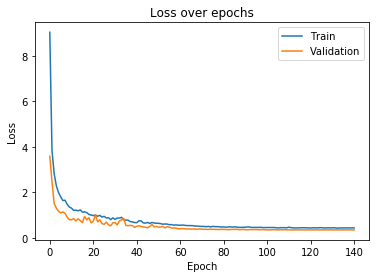

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

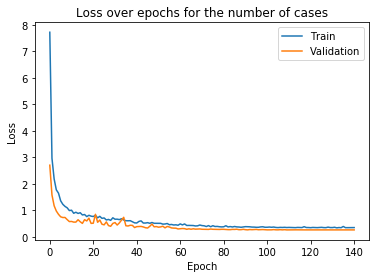

In [17]:
plt.plot(history.history['cases_loss'])
plt.plot(history.history['val_cases_loss'])
plt.title('Loss over epochs for the number of cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

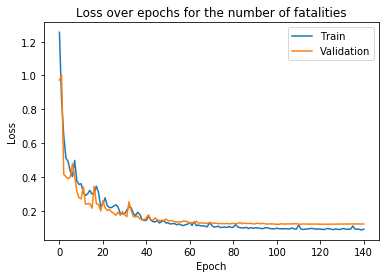

In [18]:
plt.plot(history.history['fatalities_loss'])
plt.plot(history.history['val_fatalities_loss'])
plt.title('Loss over epochs for the number of fatalities')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

## Generate predictions using the model

We can quickly check the quality of the predictions... One thing is clear, there is room for improvement!

In [19]:
model.load_weights("best_model.h5")

In [20]:
predictions = model.predict([X_temporal_test,X_demographic_test])

I only display what I call "temporal" inputs as we're simply trying to have a feeling of how well our model is fitting the trends.

In [21]:
display_limit = 30
for inputs, pred_cases, exp_cases, pred_fatalities, exp_fatalities in zip(X_temporal_test,predictions[0][:display_limit], Y_cases_test[:display_limit], predictions[1][:display_limit], Y_fatalities_test[:display_limit]):
    print("================================================")
    print(inputs)
    print("Expected cases:", exp_cases, " Prediction:", pred_cases[0], "Expected fatalities:", exp_fatalities, " Prediction:", pred_fatalities[0] )

[[0. 0. 0. 0. 0. 0. 1. 1. 5. 6. 7. 9. 9.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected cases: 12.0  Prediction: 10.986007 Expected fatalities: 0.0  Prediction: 0.0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Expected cases: 1.0  Prediction: 0.98177713 Expected fatalities: 0.0  Prediction: 0.0
[[ 1.  1.  6.  9. 13. 27. 27. 35. 39. 47. 66. 74. 81.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Expected cases: 81.0  Prediction: 108.05308 Expected fatalities: 0.0  Prediction: 0.0
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1

# Apply the model to generate novel predictions

The following functions will be used to get the 13 previous days from a given date and demographic information, predict the number of cases and fatalities, before iterating again. Therefore, it will use the prediction for the next day as part of the data for the one afterwards.

In [22]:
#Will retrieve the number of cases and fatalities for the past 6 days from the given date
def build_inputs_for_date(country, province, date, df):
    start_date = date - timedelta(days=13)
    end_date = date - timedelta(days=1)
    
    str_start_date = start_date.strftime("%Y-%m-%d")
    str_end_date = end_date.strftime("%Y-%m-%d")
    df = df.query("Country_Region=='"+country+"' and Province_State=='"+province+"' and Date>='"+str_start_date+"' and Date<='"+str_end_date+"'")
    
    #preparing the temporal inputs
    temporal_input_data = np.reshape(np.asarray([df["ConfirmedCases"],
                                                 df["Fatalities"],
                                                 df["restrictions"],
                                                 df["quarantine"],
                                                 df["schools"]]),
                                     (5,sequence_length)).astype(np.float32)
    
    #preparing all the demographic inputs
    total_population = float(province_df.iloc[i].total_pop)
    density = float(province_df.iloc[i].density)
    hospibed = float(province_df.iloc[i].hospibed)
    lung = float(province_df.iloc[i].lung)
    demographic_input_data = [total_population,density,hospibed,lung]
    
    return [np.array([temporal_input_data]), np.array([demographic_input_data])]

In [23]:
#Take a dataframe in input, will do the predictions and return the dataframe with extra rows
#containing the predictions
def predict_for_region(country, province, df):
    begin_prediction = "2020-03-19"
    start_date = datetime.strptime(begin_prediction,"%Y-%m-%d")
    end_prediction = "2020-04-30"
    end_date = datetime.strptime(end_prediction,"%Y-%m-%d")
    
    date_list = [start_date + timedelta(days=x) for x in range((end_date-start_date).days+1)]
    for date in date_list:
        input_data = build_inputs_for_date(country, province, date, df)
        result = model.predict(input_data)
        
        #just ensuring that the outputs is
        #higher than the previous counts
        
        result[0] = np.round(result[0])
        if result[0]<input_data[0][0][0][-1]:
            result[0]=np.array([[input_data[0][0][0][-1]]])
        
        result[1] = np.round(result[1])
        if result[1]<input_data[0][0][1][-1]:
            result[1]=np.array([[input_data[0][0][1][-1]]])
        
        #We assign the quarantine and school status
        #depending on previous values
        #e.g Once a country is locked, it will stay locked until the end
        df = df.append({"Country_Region":country, 
                        "Province_State":province, 
                        "Date":date.strftime("%Y-%m-%d"), 
                        "restrictions": 1 if any(input_data[0][0][2]) else 0,
                        "quarantine": 1 if any(input_data[0][0][3]) else 0,
                        "schools": 1 if any(input_data[0][0][4]) else 0,
                        "total_pop": input_data[1][0],
                        "density": input_data[1][0][1],
                        "hospibed": input_data[1][0][2],
                        "lung": input_data[1][0][3],
                        "ConfirmedCases":round(result[0][0][0]),	
                        "Fatalities":round(result[1][0][0])},
                       ignore_index=True)
    return df

In [24]:
#The functions that are called here need to optimise, sorry about that!
copy_df = train_df
with tqdm(total=len(list(copy_df.Country_Region.unique()))) as pbar:
    for country in copy_df.Country_Region.unique():
        for province in copy_df.query("Country_Region=='"+country+"'").Province_State.unique():
            copy_df = predict_for_region(country, province, copy_df)
        pbar.update(1)

100%|██████████| 294/294 [56:40<00:00, 11.57s/it]


Example

In [25]:
copy_df.query("Country_Region=='France_French Guiana' and Date>'2020-03-19'")

,Id,Country_Region,Province_State,Date,ConfirmedCases,Fatalities,age_0-4,age_5-9,age_10-14,age_15-19,...,density,urbanpop,hospibed,lung,femalelung,malelung,restrictions,quarantine,schools,geometry
21109,NaN,France_French Guiana,French Guiana,2020-03-20,18,0,NaN,NaN,NaN,NaN,...,0.003607,NaN,0.195652,0.180347,NaN,NaN,0,1,0,None
21110,NaN,France_French Guiana,French Guiana,2020-03-21,22,0,NaN,NaN,NaN,NaN,...,0.003607,NaN,0.195652,0.180347,NaN,NaN,0,1,0,None
21111,NaN,France_French Guiana,French Guiana,2020-03-22,29,0,NaN,NaN,NaN,NaN,...,0.003607,NaN,0.195652,0.180347,NaN,NaN,0,1,0,None
21112,NaN,France_French Guiana,French Guiana,2020-03-23,42,0,NaN,NaN,NaN,NaN,...,0.003607,NaN,0.195652,0.180347,NaN,NaN,0,1,0,None
21113,NaN,France_French Guiana,French Guiana,2020-03-24,51,0,NaN,NaN,NaN,NaN,...,0.003607,NaN,0.195652,0.180347,NaN,NaN,0,1,0,None
21114,NaN,France_French Guiana,French Guiana,2020-03-25,55,0,NaN,NaN,NaN,NaN,...,0.003607,NaN,0.195652,0.180347,NaN,NaN,0,1,0,None
21115,NaN,France_French Guiana,French Guiana,2020-03-26,74,0,NaN,NaN,NaN,NaN,...,0.003607,NaN,0.195652,0.180347,NaN,NaN,0,1,0,None
21116,NaN,France_French Guiana,French Guiana,2020-03-27,123,0,NaN,NaN,NaN,NaN,...,0.003607,NaN,0.195652,0.180347,NaN,NaN,0,1,0,None
21117,NaN,France_French Guiana,French Guiana,2020-03-28,123,0,NaN,NaN,NaN,NaN,...,0.003607,NaN,0.195652,0.180347,NaN,NaN,0,1,0,None
21118,NaN,France_French Guiana,French Guiana,2020-03-29,123,0,NaN,NaN,NaN,NaN,...,0.003607,NaN,0.195652,0.180347,NaN,NaN,0,1,0,None


In [26]:
test_df = gpd.read_file("/kaggle/input/covid19-global-forecasting-week-2/test.csv")
#The country_region got modifying in the enriched dataset by @optimo, 
# so we have to apply the same change to the test Dataframe.
test_df["Country_Region"] = [ row.Country_Region if row.Province_State=="" else row.Country_Region+"_"+row.Province_State for idx,row in test_df.iterrows() ]
test_df.head()

,ForecastId,Province_State,Country_Region,Date,geometry
0,1,,Afghanistan,2020-03-19,None
1,2,,Afghanistan,2020-03-20,None
2,3,,Afghanistan,2020-03-21,None
3,4,,Afghanistan,2020-03-22,None
4,5,,Afghanistan,2020-03-23,None


Just need to do this little trick to extract the relevant date and the forecastId and add that to the submission file.

In [27]:
submission_df = pd.DataFrame(columns=["ForecastId","ConfirmedCases","Fatalities"])
with tqdm(total=len(test_df)) as pbar:
    for idx, row in test_df.iterrows():
        #Had to remove single quotes because of countries like Cote D'Ivoire for example
        country_region = row.Country_Region.replace("'","").strip(" ")
        province_state = row.Province_State.replace("'","").strip(" ")
        item = copy_df.query("Country_Region=='"+country_region+"' and Province_State=='"+province_state+"' and Date=='"+row.Date+"'")
        submission_df = submission_df.append({"ForecastId":row.ForecastId,
                                              "ConfirmedCases":int(item.ConfirmedCases.values[0]),
                                              "Fatalities":int(item.Fatalities.values[0])},
                                             ignore_index=True)
        pbar.update(1)

100%|██████████| 12642/12642 [04:06<00:00, 51.32it/s]


In [28]:
submission_df.sample(20)

,ForecastId,ConfirmedCases,Fatalities
465,466,1,0
3055,3056,18,0
8313,8314,565,0
10652,10653,564,0
485,486,416,0
10730,10731,621,0
5644,5645,218,0
12620,12621,0,0
8857,8858,616,5
4124,4125,1,0


In [29]:
submission_df.to_csv("submission.csv",index=False)

### Of course, this notebook still requires a lot of work but I thought I would release a first version anyway, mainly to help anyone who could be working on a similar pipeline. I will try to update this notebook with an improved model itself and some charts to better understand our outputs in the following iterations.

### If you found this notebook helpful, please give it an upvote. It will be greatly appreciated!